In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Positive reviews are 5561 and negative reviews are 6908 of total 12469 


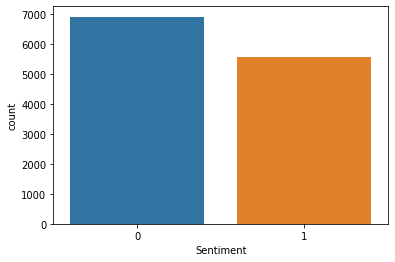

In [18]:
dataset = pd.read_csv('/content/Hotel_Reviews_modified.csv')
negative = len(dataset[dataset['Sentiment']== 0])
positive = len(dataset) - negative
sns.countplot(dataset['Sentiment'])
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive,negative,len(dataset)))

In [19]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['Review'].values,dataset['Sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

Data Pre Processing

In [20]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 7860


In [21]:
embedded_words = {}
with open('/content/glove.6B.100d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [22]:
embedding_matrix = np.zeros((len(word_index) + 1,100))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

LSTM MODEL

In [23]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,100,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])


In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          786100    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [25]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 8 ,validation_data=(test_pad_sequence,testing_labels))

Epoch 1/8
312/312 [==============================] - 66s 210ms/step - loss: 0.3292 - accuracy: 0.8664 - val_loss: 0.1993 - val_accuracy: 0.9226
Epoch 2/8
312/312 [==============================] - 66s 210ms/step - loss: 0.2045 - accuracy: 0.9274 - val_loss: 0.1880 - val_accuracy: 0.9282
Epoch 3/8
312/312 [==============================] - 66s 210ms/step - loss: 0.1795 - accuracy: 0.9360 - val_loss: 0.1664 - val_accuracy: 0.9362
Epoch 4/8
312/312 [==============================] - 66s 211ms/step - loss: 0.1622 - accuracy: 0.9390 - val_loss: 0.1605 - val_accuracy: 0.9435
Epoch 5/8
312/312 [==============================] - 68s 217ms/step - loss: 0.1521 - accuracy: 0.9470 - val_loss: 0.1534 - val_accuracy: 0.9431
Epoch 6/8
312/312 [==============================] - 66s 213ms/step - loss: 0.1583 - accuracy: 0.9440 - val_loss: 0.1559 - val_accuracy: 0.9407
Epoch 7/8
312/312 [==============================] - 66s 213ms/step - loss: 0.1347 - accuracy: 0.9517 - val_loss: 0.1620 - val_accuracy:

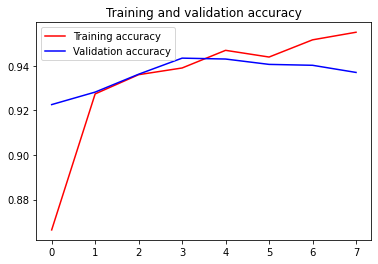

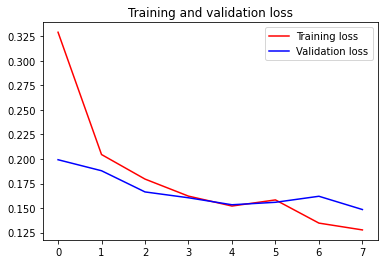

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [27]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.9550877213478088
Validation Accuracy: 0.9434643387794495
